In [34]:
'''
Trains a Siamese CNN on pairs of faces from FRAV-Attack dataset.
It follows Hadsell-et-al.'06 [1] by computing the Euclidean distance on the
output of the shared network and by optimizing the contrastive loss (see paper
for more details).
The point is use Relaxed Contractive Loss in order to achieve intra-class discrimination accuracy improvement
to detect fake face attacks.

# References
- Dimensionality Reduction by Learning an Invariant Mapping
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
- Ryan et all
- Ryan et all
- FDK et all

Gets to 97.2% test accuracy after 20 epochs.
2 seconds per epoch on a Titan X Maxwell GPU

25/05/2021
15/06/2021
Tensorflow 2 keras version
'''
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
import sys
import os

import matplotlib.pyplot as plt
import cv2

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from time import time
from matplotlib import offsetbox


num_classes = 10

print("tf2=",tf.__version__)
print("keras=",tf.keras.__version__)
print("cv2=",cv2.__version__)
print("python=",sys.version_info)

tf2= 2.4.1
keras= 2.4.0
cv2= 4.5.1
python= sys.version_info(major=3, minor=8, micro=8, releaselevel='final', serial=0)


In [35]:
def rotate(img, angle):
    #img = cv2.imread(img)
    (height, width) = img.shape[:2]
    (cent_x, cent_y) = (width // 2, height // 2)
    mat = cv2.getRotationMatrix2D((cent_x, cent_y), -angle, 1.0)
    return cv2.warpAffine(img, mat,(height, width))

In [36]:
# ----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, x_images, tr_dy, title=None,threshold=7e-2,sh=28,sw=28,thumbnails=True):
    #Resize Images
    images = np.zeros((x_images.shape[0], sh, sw,3))
    for i in range(x_images.shape[0]):
        images[i] = cv2.resize(x_images[i], (sh,sw), interpolation = cv2.INTER_AREA)
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    #X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=[9.0, 9.0])
    ax = plt.subplot(111)
    #for i in range(X.shape[0]):
    print("tr_dy=",tr_dy.shape)
    plt.scatter(X[:, 0], X[:, 1], c=tr_dy,cmap=plt.get_cmap("gist_rainbow"), label=tr_dy)
    #plt.scatter(X[:, 0], X[:, 1],  label=tr_dy)

    if hasattr(offsetbox, 'AnnotationBbox') and thumbnails:
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < threshold:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.colorbar()
    #plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
def plot_tSNE_2D(X, tr_dx, tr_dy, title=None,threshold=7e-2,sh=28,sw=28,thumbnails=True):
    # ----------------------------------------------------------------------
    # t-SNE embedding of the digits dataset
    tsne = tsne = TSNE(n_components=2, random_state=1, n_iter=1000)
    t0 = time()
    X_tsne = tsne.fit_transform(X)
    plot_embedding(X_tsne, tr_dx, tr_dy,
               "t-SNE Plot of the Embeddings (time %.2fs)" %
               (time() - t0),threshold=7e-2,sh=28,sw=28,thumbnails=True)


In [37]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss_relax(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1.0
    #square_pred = K.square(y_pred)
    square_pred = K.maximum(y_pred-margin, 0) #y_pred #K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0.0))
    tcost=y_true * square_pred
    fcost=(1.0 - y_true) * margin_square
    return K.mean(tcost + fcost)


In [38]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for m in range(1):
        for d in range(num_classes):
            for i in range(n):
                ridx=random.randrange(1,n)
                idx=(i+ridx)%n
                z1, z2 = digit_indices[d][i], digit_indices[d][idx]
                pairs += [[x[z1], x[z2]]]
                inc = random.randrange(1, num_classes)
                dn = (d + inc) % num_classes
                z1, z2 = digit_indices[d][i], digit_indices[dn][i]
                pairs += [[x[z1], x[z2]]]
                labels += [1.0, 0.0]
    return np.array(pairs).astype("float32"), np.array(labels).astype("float32")

In [39]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(input)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    #for 2D view
    x = Dense(  2)(x)
    return Model(input, x)

In [40]:
# Accuracy for the moment is just put in the same class
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [41]:
path_base="/home/francisco/datasets/datasets/pictures/FRAV-Attack/RS/NIR/faces_NIR_crop"
def fravAttack_load_data():
    images=[]
    labels=[]
    attacks=["user","attack_02"]
    for fName in sorted(os.listdir(path_base))[:]:
        fNameNotExt,fext=fName.split(".")
        user,attack,frameId=fNameNotExt.split("-")
        uid=int(user.split("_")[-1])
        if uid>=10:break
        if not attack in attacks: continue
        fullFName=os.path.join(path_base,fName)
        cvImg=cv2.imread(fullFName)
        cvImg=cv2.cvtColor(cvImg,cv2.COLOR_BGR2RGB)
        cvImg=cv2.resize(cvImg,(64,64))
        #if ret==None:
        #    print("Error reading image=",fullFName)
        images.append(cvImg)
        labels.append(uid)
        #print(fName,uid)
    labelNames=set(labels)
    print("labels=",labelNames,len(labelNames))
    images=np.array(images)
    labels=np.array(labels)
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)
    return (X_train, y_train), (X_test, y_test)
(x_train, y_train), (x_test, y_test) =fravAttack_load_data()

labels= {0, 1, 2, 3, 4, 5, 6, 7, 8, 9} 10


In [42]:
# the data, split between train and test sets
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype("float32")
y_test  = y_test.astype("float32")
x_train /= 255
x_test /= 255
#input_shape = (x_train.shape[1],x_train.shape[1],1)
input_shape = x_train.shape[1:]

print(x_train.shape)
print(y_train.shape)

(929, 64, 64, 3)
(929,)


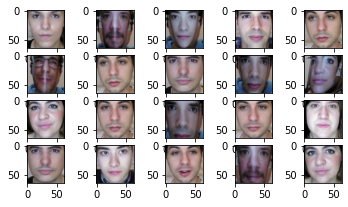

In [43]:
for i in range(20):
    plt.subplot(5,5,i+1)
    idx=random.randrange(0,x_train.shape[0])
    plt.imshow(x_train[idx])
plt.show()

In [44]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test  == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

print("tr_pairs=",tr_pairs.shape,"tr_y=",tr_y.shape,tr_y.dtype)
print("te_pairs=",te_pairs.shape,"te_y=",te_y.shape,te_y.dtype)

tr_pairs= (1580, 2, 64, 64, 3) tr_y= (1580,) float32
te_pairs= (100, 2, 64, 64, 3) te_y= (100,) float32


In [45]:
# network definition
def buildModel(base_network):
    # network definition
    #base_network = create_base_network(input_shape)

    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    # because we re-use the same instance `base_network`,
    # the weights of the network
    # will be shared across the two branches
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    distance = Lambda(euclidean_distance,
                      output_shape=eucl_dist_output_shape)([processed_a, processed_b])

    model = Model([input_a, input_b], distance)
    return model

In [46]:
base_network = create_base_network(input_shape)
model=buildModel(base_network)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
model_6 (Functional)            (None, 2)            33626562    input_10[0][0]                   
                                                                 input_11[0][0]                   
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0           model_6[0][0]              

In [47]:
batch_size=128
encoder=base_network#check this
# display a 2D plot of the digit classes in the latent space
#ex_test=np.expand_dims(x_train,axis=-1) #for grayscale images
x_test_encoded = encoder.predict(x_train, batch_size=batch_size)

y_train= (929,)
tr_dy= (929,)


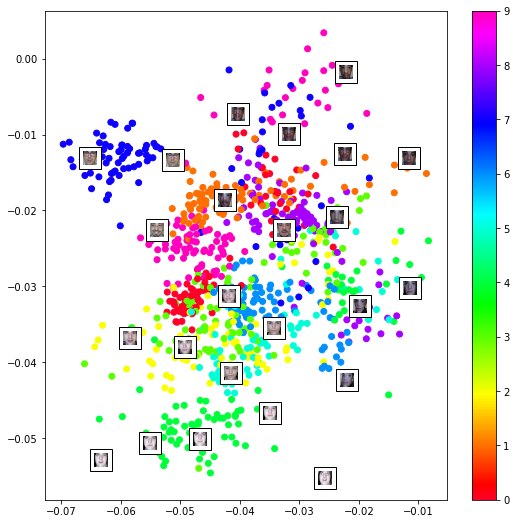

In [48]:
print("y_train=",y_train.shape)
plot_embedding(x_test_encoded, x_train, y_train, title=None,threshold=7e-5,sh=14,sw=14)

In [49]:
# train
epochs = 20
batch_size=100
rms = RMSprop()
model.compile(loss=contrastive_loss_relax, optimizer=rms, metrics=[accuracy])

In [52]:
print("tr_pairs=",tr_pairs.shape)
print("tr_y=",tr_y.shape)
print("te_pairs=",te_pairs.shape)
print("te_y=",te_y.shape)
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

tr_pairs= (1580, 2, 64, 64, 3)
tr_y= (1580,)
te_pairs= (100, 2, 64, 64, 3)
te_y= (100,)
Epoch 1/20
13/13 [==============================] - 2s 118ms/step - loss: 0.0016 - accuracy: 0.8803 - val_loss: 4.2343e-05 - val_accuracy: 0.9700
Epoch 2/20
13/13 [==============================] - 1s 106ms/step - loss: 0.0033 - accuracy: 0.8629 - val_loss: 0.0000e+00 - val_accuracy: 0.9600
Epoch 3/20
13/13 [==============================] - 1s 109ms/step - loss: 0.0027 - accuracy: 0.8645 - val_loss: 7.1781e-05 - val_accuracy: 0.9500
Epoch 4/20
13/13 [==============================] - 1s 109ms/step - loss: 0.0017 - accuracy: 0.8927 - val_loss: 0.0000e+00 - val_accuracy: 0.9200
Epoch 5/20
13/13 [==============================] - 1s 109ms/step - loss: 0.0010 - accuracy: 0.8730 - val_loss: 0.0020 - val_accuracy: 0.8200
Epoch 6/20
13/13 [==============================] - 1s 109ms/step - loss: 0.0052 - accuracy: 0.8668 - val_loss: 0.0016 - val_accuracy: 0.8300
Epoch 7/20
13/13 [==========================

In [20]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 98.99%
* Accuracy on test set: 98.00%


tr_dy= (929,)


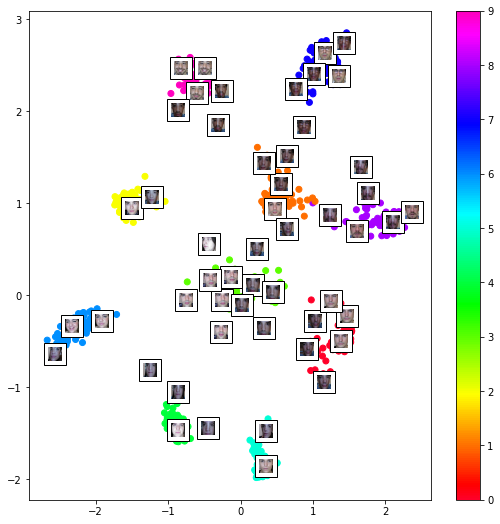

In [53]:
batch_size=128
encoder=base_network#check this
# display a 2D plot of the digit classes in the latent space
#ex_test=np.expand_dims(tr_dx,axis=-1)
x_test_encoded = encoder.predict(x_train, batch_size=batch_size)
plot_embedding(x_test_encoded, x_train, y_train, title=None,threshold=7e-2,sh=14,sw=14,thumbnails=True)

tr_dy= (104,)


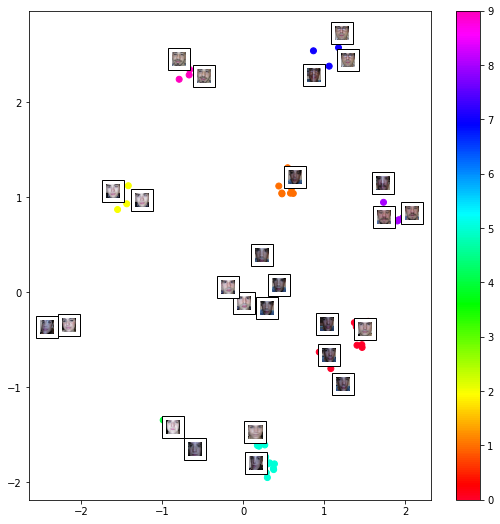

In [54]:
batch_size=128
encoder=base_network#check this
# display a 2D plot of the digit classes in the latent space
#ex_test=np.expand_dims(tr_dx,axis=-1)
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plot_embedding(x_test_encoded, x_test, y_test, title=None,threshold=7e-2,sh=14,sw=14,thumbnails=True)

In [21]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_dx,tr_dy,tr_pairs, tr_y = create_pairs_intra(x_train, digit_indices,10,[4,9])
print("tr_pairs=",tr_pairs.shape,"tr_y=",tr_y.shape,tr_y.dtype)

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
tr_pairs= (370, 4, 32, 32, 3, 1) tr_y= (370, 2) float32


In [22]:
# network definition
base_network = create_base_network(input_shape)
model = buildModel()

In [55]:
batch_size=128
encoder=base_network#check this
# display a 2D plot of the digit classes in the latent space
ex_test=np.expand_dims(tr_dx,axis=-1)
x_test_encoded = encoder.predict(ex_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=tr_dy,cmap=plt.get_cmap("gist_rainbow"))
plt.colorbar()
plt.show()
plot_embedding(x_test_encoded, tr_dx, tr_dy, title=None,threshold=7e-3,sh=14,sw=14)

NameError: name 'tr_dx' is not defined

In [21]:
rms = RMSprop()
model.compile(loss=contrastive_loss_intra_hard, optimizer=rms, metrics=[accuracy])

In [30]:
# train
epochs = 10
batch_size=1000
model.fit([tr_pairs[:, 0], tr_pairs[:, 1],tr_pairs[:, 2], tr_pairs[:, 3]], tr_y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1],te_pairs[:, 2], te_pairs[:, 3]], te_y))

Epoch 1/10
1/1 [==============================] - 0s 491ms/step - loss: 0.0566 - accuracy: 0.7054 - val_loss: 0.2785 - val_accuracy: 0.5359
Epoch 2/10
1/1 [==============================] - 0s 461ms/step - loss: 0.0485 - accuracy: 0.6946 - val_loss: 0.2338 - val_accuracy: 0.5410
Epoch 3/10
1/1 [==============================] - 0s 473ms/step - loss: 0.0435 - accuracy: 0.6986 - val_loss: 0.2654 - val_accuracy: 0.5349
Epoch 4/10
1/1 [==============================] - 0s 454ms/step - loss: 0.0478 - accuracy: 0.7014 - val_loss: 0.2278 - val_accuracy: 0.5477
Epoch 5/10
1/1 [==============================] - 0s 443ms/step - loss: 0.0567 - accuracy: 0.7000 - val_loss: 0.2787 - val_accuracy: 0.5364
Epoch 6/10
1/1 [==============================] - 0s 456ms/step - loss: 0.0577 - accuracy: 0.7000 - val_loss: 0.2340 - val_accuracy: 0.5440
Epoch 7/10
1/1 [==============================] - 0s 444ms/step - loss: 0.0741 - accuracy: 0.7297 - val_loss: 0.2498 - val_accuracy: 0.5306
Epoch 8/10
1/1 [====

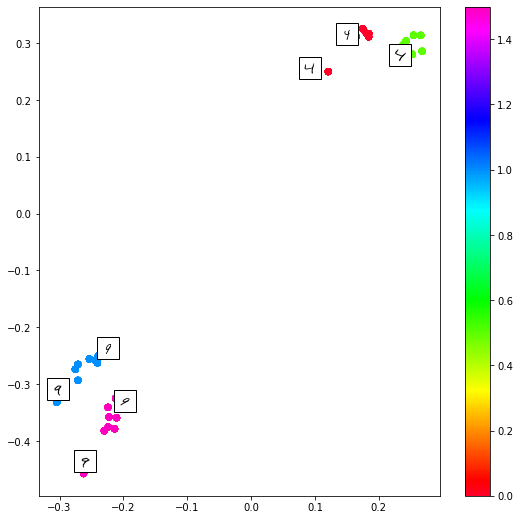

In [31]:
batch_size=128
encoder=base_network#check this
# display a 2D plot of the digit classes in the latent space
ex_test=np.expand_dims(tr_dx,axis=-1)
x_test_encoded = encoder.predict(ex_test, batch_size=batch_size)
plot_embedding(x_test_encoded, tr_dx, tr_dy, title=None,threshold=7e-3,sh=14,sw=14)

Computing t-SNE embedding


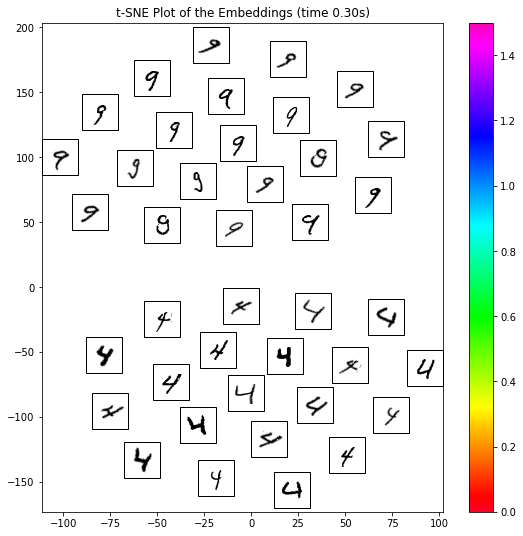

In [32]:
 #Test Model
batch_size=128
encoder=base_network
ex_test=np.expand_dims(tr_dx,axis=-1)
x_test_encoded = encoder.predict(ex_test, batch_size=batch_size)

# Plot results with T-SNE
X = x_test_encoded
y = tr_dy


n_samples = x_test_encoded.shape[0]
n_feature = 128
n_neighbors = 0


# ----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = tsne = TSNE(n_components=2, random_state=1, n_iter=1000)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne, tr_dx, tr_dy,
               "t-SNE Plot of the Embeddings (time %.2fs)" %
               (time() - t0))

